# IBM Applied Data Science Capstone Course by Coursera

**This project aims to apply the skills learned from this series of course to solve the real business problems. It is an implementation of entire data science pipeline including data collection, data cleaning, exploration data analysis, mearning learning process, visualization and information delivery.**

The topic of this project is to recommend a location for opening a new Italian restaurant in Chicago central area. 

Firstly, Import necessary libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup # scrap the web
import requests

import geocoder # obtain the longitude and latitide

import seaborn as sns  # draw figures
import matplotlib.pyplot as plt


print('Libraries imported.')

Libraries imported.


## 1. Data Collection

Web scraping to get the neighborhood name of Chicago central area

In [3]:
data = requests.get('https://en.wikipedia.org/wiki/Community_areas_in_Chicago').text
soup = BeautifulSoup(data,'lxml')

In [4]:
neighborhoodList = []
n=1
for row in soup.find('table').find_all('tr'):
    for element in row.find_all('td'):
        li = element.find_all("li")
        while n <= len(li):
            neighborhoodList.append(li[n-1].text)
            n = n+1
        n = 1
        
print ((neighborhoodList))

['Cabrini–Green', 'The Gold Coast', 'Goose Island', 'Magnificent Mile', 'Old Town', 'River North', 'River West', 'Streeterville', 'Loop', 'New Eastside', 'South Loop', 'West Loop Gate', 'Dearborn Park', "Printer's Row", 'South Loop', 'Prairie Avenue Historic District']


Add coordination information to corresponding neighborhood

In [5]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Chicago, USA'.format(neighborhood))
        lat_lng_coords = g.latlng
#        print(lat_lng_coords[0])
        lat.append(lat_lng_coords[0])
        lon.append(lat_lng_coords[1])
        print(lat_lng_coords)
    return lat_lng_coords

In [6]:
lat=[]
lon=[]

coords = [ get_latlng(neighborhood) for neighborhood in neighborhoodList ]

len(coords)

[41.8714245, -87.6537405]
[41.903950000000066, -87.62885999999997]
[34.78681000000006, -84.40606999999994]
[41.90058000000005, -87.62420999999995]
[41.90539000000007, -87.64178999999996]
[41.89252000000005, -87.62476999999996]
[41.94878713053188, -87.85596650236198]
[41.898430000000076, -87.62140999999997]
[41.87834000000004, -87.61996999999997]
[41.71207000000004, -87.53067999999996]
[41.874540000000025, -87.62883999999997]
[41.7907101595921, -87.61416746161797]
[41.87227000000007, -87.62868999999995]
[41.87369000000007, -87.62965007718253]
[41.874540000000025, -87.62883999999997]
[41.85642000000007, -87.62087999999994]


16

Creat dataframe with the location infoamation 

In [7]:
data = {'Neighborhood':neighborhoodList,'Latitude':lat,'Longitude':lon }
df_coords = pd.DataFrame(data)
df_coords

,Neighborhood,Latitude,Longitude
0,Cabrini–Green,41.871425,-87.653740
1,The Gold Coast,41.903950,-87.628860
2,Goose Island,34.786810,-84.406070
3,Magnificent Mile,41.900580,-87.624210
4,Old Town,41.905390,-87.641790
5,River North,41.892520,-87.624770
6,River West,41.948787,-87.855967
7,Streeterville,41.898430,-87.621410
8,Loop,41.878340,-87.619970
9,New Eastside,41.712070,-87.530680


Data Cleaning: South Loop occurs more than one time

In [8]:
df_coords = df_coords.drop_duplicates()
print(df_coords.shape)
df_coords

(15, 3)


,Neighborhood,Latitude,Longitude
0,Cabrini–Green,41.871425,-87.653740
1,The Gold Coast,41.903950,-87.628860
2,Goose Island,34.786810,-84.406070
3,Magnificent Mile,41.900580,-87.624210
4,Old Town,41.905390,-87.641790
5,River North,41.892520,-87.624770
6,River West,41.948787,-87.855967
7,Streeterville,41.898430,-87.621410
8,Loop,41.878340,-87.619970
9,New Eastside,41.712070,-87.530680


Request information of venues in each neighborhood using Foursquare

In [9]:

VERSION = '20180605'
radius = 500
LIMIT = 100

In [10]:
venues = []

for lat, lon, neighborhood in zip(df_coords['Latitude'], df_coords['Longitude'],df_coords['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lon,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']

    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            lon, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))


Create a dataframe containing venue information

In [11]:
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = [ 'Neighborhood', 'NeighborLatitude', 'NeighborLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head(20)

(821, 7)


,Neighborhood,NeighborLatitude,NeighborLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Cabrini–Green,41.871425,-87.65374,Fontano's Subs,41.871888,-87.653545,Sandwich Place
1,Cabrini–Green,41.871425,-87.65374,Mario's Italian Lemonade,41.869529,-87.653783,Dessert Shop
2,Cabrini–Green,41.871425,-87.65374,Tufano's Vernon Park Tap,41.872904,-87.654241,Italian Restaurant
3,Cabrini–Green,41.871425,-87.65374,Tuscany,41.869631,-87.651807,Italian Restaurant
4,Cabrini–Green,41.871425,-87.65374,Sheridan Park,41.871006,-87.654599,Park
5,Cabrini–Green,41.871425,-87.65374,Al's Italian Beef,41.869365,-87.653964,Sandwich Place
6,Cabrini–Green,41.871425,-87.65374,First Aid Comics - Taylor St.,41.869453,-87.656119,Hobby Shop
7,Cabrini–Green,41.871425,-87.65374,Chez Joel,41.869461,-87.655117,French Restaurant
8,Cabrini–Green,41.871425,-87.65374,Busy Burger,41.869548,-87.655277,Burger Joint
9,Cabrini–Green,41.871425,-87.65374,RoSal's Italian Cucina,41.869504,-87.656415,Italian Restaurant


## 2. Data Analysis

In [19]:
df_group = venues_df.groupby([ "Neighborhood"]).count()
print(df_group.shape)
df_group.drop(["NeighborLongitude","NeighborLatitude","VenueName","VenueLatitude","VenueLongitude"], 1)


(14, 6)


,VenueCategory
Neighborhood,
Cabrini–Green,43
Dearborn Park,67
Loop,48
Magnificent Mile,100
New Eastside,5
Old Town,24
Prairie Avenue Historic District,36
Printer's Row,90
River North,100


However, there is one row missing from the scraped neighborhood list. There might be no exploration result in Foursquare.

In [16]:
venues_df[venues_df["Neighborhood"] =="Goose Island"]

,Neighborhood,NeighborLatitude,NeighborLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory


In [17]:
pd.concat([df_group["Neighborhood"],df_coords["Neighborhood"]]).drop_duplicates(keep=False)

2    Goose Island
Name: Neighborhood, dtype: object

Discussion: The hyphothesis is correct. There is no exploration result for "Goose Island". Drop this row from the original dataframe.

In [18]:
df_coords = df_coords[df_coords.Neighborhood!="Goose Island"]
print(df_coords.index)
df_coords.drop(df_coords.index)
df_coords


Int64Index([0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15], dtype='int64')


,Neighborhood,Latitude,Longitude
0,Cabrini–Green,41.871425,-87.653740
1,The Gold Coast,41.903950,-87.628860
3,Magnificent Mile,41.900580,-87.624210
4,Old Town,41.905390,-87.641790
5,River North,41.892520,-87.624770
6,River West,41.948787,-87.855967
7,Streeterville,41.898430,-87.621410
8,Loop,41.878340,-87.619970
9,New Eastside,41.712070,-87.530680
10,South Loop,41.874540,-87.628840


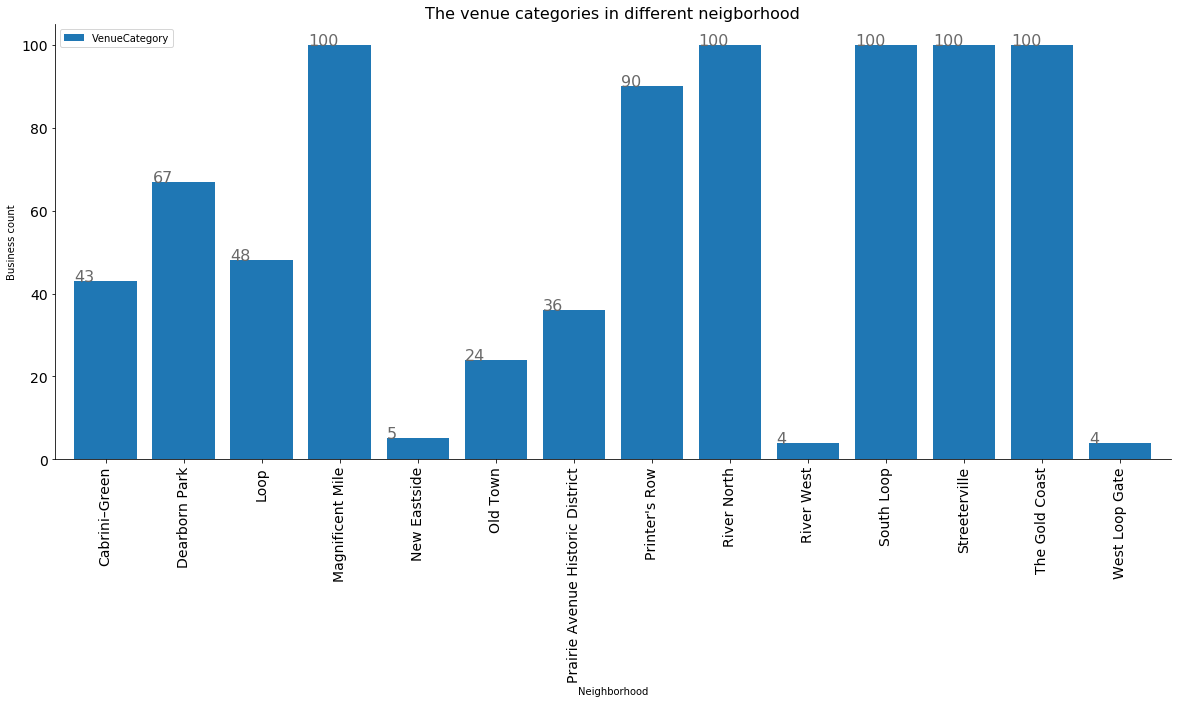

In [20]:
ax = df_group[["VenueCategory"]].plot(kind = "bar", figsize = (20,8), width = 0.8,  fontsize=14 )
ax.set_title("The venue categories in different neigborhood", fontsize = 16)
ax.set_ylabel("Business count")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(),i.get_height(),str(i.get_height()), fontsize=16, color='dimgrey')

Discussion: In the central chicago, most venues locate in the South Loop

Find the most popular categories 

In [21]:
# one hot encoding
chicago_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chicago_onehot['Neighborhood'] = venues_df['Neighborhood'] 

# move neighborhood column to the first column
cols=list(chicago_onehot.columns.values)
cols.pop(cols.index('Neighborhood'))
chicago_onehot=chicago_onehot[['Neighborhood']+cols]

print(chicago_onehot.shape)
chicago_onehot.head()

(821, 164)


,Neighborhood,Accessories Store,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bed & Breakfast,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Bus Station,Cafeteria,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Stadium,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Entertainment Service,Farmers Market,Fast Food Restaurant,Food Court,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Non-Profit,Optical Shop,Other Repair Shop,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Pet Service,Pharmacy,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train Station,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Cabrini–Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Cabrini–Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Cabrini–Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Cabrini–Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Cabrini–Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
chicago_grouped = chicago_onehot.groupby(['Neighborhood']).mean().reset_index()
print(chicago_grouped.shape)
chicago_grouped.head()

(14, 164)


,Neighborhood,Accessories Store,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bed & Breakfast,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Bus Station,Cafeteria,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Stadium,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Entertainment Service,Farmers Market,Fast Food Restaurant,Food Court,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Non-Profit,Optical Shop,Other Repair Shop,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Pet Service,Pharmacy,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train Station,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Cabrini–Green,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.023256,0.023256,0.046512,0.00,0.0,0.000000,0.0,0.0,0.0000,0.023256,0.000000,0.023256,0.0,0.023256,0.0,0.000000,0.023256,0.0,0.0,0.023256,0.0,0.046512,0.00,0.00,0.0,0.023256,0.023256,0.000000,0.023256,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.00,0.023256,0.000000,0.0,0.0,0.023256,0.0,0.0,0.000000,0.023256,0.00,0.0,0.000000,0.023256,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.00,0.0,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069767,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.023256,0.0,0.0,0.00,0.000000,0.00,0.023256,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.023256,0.0,0.00,0.000000,0.000000,0.069767,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.023256,0.139535,0.00,0.000000,0.000000,0.023256,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.000000,0.023256,0.00,0.0,0.0,0.023256,0.000000,0.000000,0.023256,0.046512,0.023256,0.00,0.000000,0.00,0.000000,0.0,0.023256,0.0,0.00,0.000000
1,Dearborn Park,0.0,0.044776,0.000000,0.0,0.000000,0.014925,0.014925,0.0,0.0,0.0,0.014925,0.000000,0.000000,0.00,0.0,0.014925,0.0,0.0,0.0000,0.014925,0.014925,0.000000,0.0,0.000000,0.0,0.014925,0.014925,0.0,0.0,0.000000,0.0,0.000000,0.00,0.00,0.0,0.029851,0.000000,0.000000,0.000000,0.029851,0.014925,0.00,0.0,0.029851,0.0,0.00,0.000000,0.014925,0.0,0.0,0.000000,0.0,0.0,0.014925,0.000000,0.00,0.0,0.014925,0.000000,0.014925,0.0,0.029851,0.014925,0.014925,0.000000,0.0,0.0,0.0,0.0,0.029851,0.059701,0.0000,0.0,0.0,0.00,0.0,0.000000,0.014925,0.014925,0.044776,0.014925,0.014925,0.029851,0.000000,0.014925,0.014925,0.01

The number of venues in each category

In [133]:
chicago_sum = chicago_onehot.groupby(['Neighborhood']).sum().reset_index()
print(chicago_sum.shape)
chicago_sum.head()

(14, 164)


,Neighborhood,Accessories Store,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bed & Breakfast,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Bus Station,Cafeteria,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Stadium,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Entertainment Service,Farmers Market,Fast Food Restaurant,Food Court,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Non-Profit,Optical Shop,Other Repair Shop,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Pet Service,Pharmacy,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train Station,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Cabrini–Green,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,2,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,6,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,2,1,0,0,0,0,0,1,0,0,0
1,Dearborn Park,0,3,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,2,1,0,0,2,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,2,1,1,0,0,0,0,0,2,4,0,0,0,0,0,0,1,1,3,1,1,2,0,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,4,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,1
2,Loop,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,2,1,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,2,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,2,0,0,0,0,0,0,3,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,Magnificent Mile,0,11,0,0,0,1,0,0,0,0,2,0,1,1,0,0,0,0,0,0,5,0,0,2,0,0,1,0,0,1,0,0,1,5,0,3,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,9,2,0,0,0,4,1,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,3,0,0,2,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,3,0,0,0,3,0,1,0,1,0,0,2,0,1,3,0,1,0,0,4,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,3,1
4,New Eastside,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [23]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chicago_grouped['Neighborhood']

for ind in np.arange(chicago_grouped.shape[0]):
    row_categories = chicago_grouped.iloc[ind, 1:]#.iloc[1:]
    
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    neighborhoods_venues_sorted.iloc[ind, 1:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(14, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cabrini–Green,Sandwich Place,Italian Restaurant,Pizza Place,Chinese Restaurant,Thai Restaurant,Bar,Salon / Barbershop,Bowling Alley,Fast Food Restaurant,Shipping Store
1,Dearborn Park,Pizza Place,Gym / Fitness Center,American Restaurant,Hotel,Tapas Restaurant,Coffee Shop,Furniture / Home Store,Indian Restaurant,Dance Studio,Cosmetics Shop
2,Loop,Harbor / Marina,Park,Boat or Ferry,Sushi Restaurant,Garden,Fountain,Museum,Music Venue,Concert Hall,Coffee Shop
3,Magnificent Mile,American Restaurant,Hotel,Boutique,Clothing Store,Italian Restaurant,Steakhouse,Restaurant,New American Restaurant,Coffee Shop,Salon / Barbershop
4,New Eastside,Pizza Place,Italian Restaurant,Shipping Store,Train Station,Beach,Yoga Studio,Donut Shop,Forest,Food Court,Fast Food Restaurant
5,Old Town,Park,Bar,Salon / Barbershop,Martial Arts Dojo,Middle Eastern Restaurant,Seafood Restaurant,Shipping Store,Coffee Shop,Bike Rental / Bike Share,Big Box Store
6,Prairie Avenue Historic District,Historic Site,American Restaurant,Pizza Place,Café,Park,Hotel,Candy Store,Restaurant,Seafood Restaurant,Rental Car Location
7,Printer's Row,Pizza Place,Coffee Shop,American Restaurant,Gym / Fitness Center,Hotel,Sandwich Place,Ice Cream Shop,Taco Place,Lounge,Pub
8,River North,Hotel,Italian Restaurant,American Restaurant,New American Restaurant,Pizza Place,Cosmetics Shop,Steakhouse,Coffee Shop,Seafood Restaurant,Gastropub
9,River West,Gym,Other Repair Shop,Forest,Shipping Store,Food Court,Fast Food Restaurant,Farmers Market,Entertainment Service,Dry Cleaner,Donut Shop


Clustering 

In [24]:
# set number of clusters
kclusters = 4

toronto_group_clustering = chicago_grouped.drop(["Neighborhood"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_group_clustering)

(kmeans.labels_)

array([0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 1])

Join the dataframe with labels

In [25]:
chicago_merged = df_coords.copy()

# add clustering labels
chicago_merged['Cluster Labels'] = kmeans.labels_

chicago_merged = chicago_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

chicago_merged

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cabrini–Green,41.871425,-87.653740,0,Sandwich Place,Italian Restaurant,Pizza Place,Chinese Restaurant,Thai Restaurant,Bar,Salon / Barbershop,Bowling Alley,Fast Food Restaurant,Shipping Store
1,The Gold Coast,41.903950,-87.628860,0,Italian Restaurant,Clothing Store,American Restaurant,Gym,Café,Coffee Shop,Boutique,Steakhouse,Bar,Shoe Store
3,Magnificent Mile,41.900580,-87.624210,0,American Restaurant,Hotel,Boutique,Clothing Store,Italian Restaurant,Steakhouse,Restaurant,New American Restaurant,Coffee Shop,Salon / Barbershop
4,Old Town,41.905390,-87.641790,0,Park,Bar,Salon / Barbershop,Martial Arts Dojo,Middle Eastern Restaurant,Seafood Restaurant,Shipping Store,Coffee Shop,Bike Rental / Bike Share,Big Box Store
5,River North,41.892520,-87.624770,3,Hotel,Italian Restaurant,American Restaurant,New American Restaurant,Pizza Place,Cosmetics Shop,Steakhouse,Coffee Shop,Seafood Restaurant,Gastropub
6,River West,41.948787,-87.855967,0,Gym,Other Repair Shop,Forest,Shipping Store,Food Court,Fast Food Restaurant,Farmers Market,Entertainment Service,Dry Cleaner,Donut Shop
7,Streeterville,41.898430,-87.621410,0,American Restaurant,Hotel,Clothing Store,Restaurant,Salon / Barbershop,Tea Room,Italian Restaurant,Women's Store,New American Restaurant,Sporting Goods Shop
8,Loop,41.878340,-87.619970,0,Harbor / Marina,Park,Boat or Ferry,Sushi Restaurant,Garden,Fountain,Museum,Music Venue,Concert Hall,Coffee Shop
9,New Eastside,41.712070,-87.530680,0,Pizza Place,Italian Restaurant,Shipping Store,Train Station,Beach,Yoga Studio,Donut Shop,Forest,Food Court,Fast Food Restaurant
10,South Loop,41.874540,-87.628840,2,Coffee Shop,Pizza Place,American Restaurant,Sandwich Place,Gym / Fitness Center,Hotel,Bookstore,Farmers Market,Taco Place,Donut Shop


Examine which label is suitable for resuaruant

In [220]:
g = geocoder.arcgis('Chicago,IL, USA')
lat_lng_coords = g.latlng
latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]

In [27]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Neighborhood'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Examine Cluster 1

In [28]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 0]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cabrini–Green,41.871425,-87.653740,0,Sandwich Place,Italian Restaurant,Pizza Place,Chinese Restaurant,Thai Restaurant,Bar,Salon / Barbershop,Bowling Alley,Fast Food Restaurant,Shipping Store
1,The Gold Coast,41.903950,-87.628860,0,Italian Restaurant,Clothing Store,American Restaurant,Gym,Café,Coffee Shop,Boutique,Steakhouse,Bar,Shoe Store
3,Magnificent Mile,41.900580,-87.624210,0,American Restaurant,Hotel,Boutique,Clothing Store,Italian Restaurant,Steakhouse,Restaurant,New American Restaurant,Coffee Shop,Salon / Barbershop
4,Old Town,41.905390,-87.641790,0,Park,Bar,Salon / Barbershop,Martial Arts Dojo,Middle Eastern Restaurant,Seafood Restaurant,Shipping Store,Coffee Shop,Bike Rental / Bike Share,Big Box Store
6,River West,41.948787,-87.855967,0,Gym,Other Repair Shop,Forest,Shipping Store,Food Court,Fast Food Restaurant,Farmers Market,Entertainment Service,Dry Cleaner,Donut Shop
7,Streeterville,41.898430,-87.621410,0,American Restaurant,Hotel,Clothing Store,Restaurant,Salon / Barbershop,Tea Room,Italian Restaurant,Women's Store,New American Restaurant,Sporting Goods Shop
8,Loop,41.878340,-87.619970,0,Harbor / Marina,Park,Boat or Ferry,Sushi Restaurant,Garden,Fountain,Museum,Music Venue,Concert Hall,Coffee Shop
9,New Eastside,41.712070,-87.530680,0,Pizza Place,Italian Restaurant,Shipping Store,Train Station,Beach,Yoga Studio,Donut Shop,Forest,Food Court,Fast Food Restaurant
11,West Loop Gate,41.790710,-87.614167,0,Bookstore,Fast Food Restaurant,Park,Dog Run,Dry Cleaner,French Restaurant,Fountain,Forest,Food Court,Farmers Market
12,Dearborn Park,41.872270,-87.628690,0,Pizza Place,Gym / Fitness Center,American Restaurant,Hotel,Tapas Restaurant,Coffee Shop,Furniture / Home Store,Indian Restaurant,Dance Studio,Cosmetics Shop


In [29]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 1]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Prairie Avenue Historic District,41.85642,-87.62088,1,Historic Site,American Restaurant,Pizza Place,Café,Park,Hotel,Candy Store,Restaurant,Seafood Restaurant,Rental Car Location


In [30]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 2]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,South Loop,41.87454,-87.62884,2,Coffee Shop,Pizza Place,American Restaurant,Sandwich Place,Gym / Fitness Center,Hotel,Bookstore,Farmers Market,Taco Place,Donut Shop


In [31]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 3]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,River North,41.89252,-87.62477,3,Hotel,Italian Restaurant,American Restaurant,New American Restaurant,Pizza Place,Cosmetics Shop,Steakhouse,Coffee Shop,Seafood Restaurant,Gastropub


In [32]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 4]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


Discussion: The neighborhoods labelled by 0 or 3 might be a proper area to open an Italian restaurant.

### 3. Distribution of existing Italian Restaurants

Find the Italian Restaurants in central Chicago

In [33]:
df_itialian = venues_df[venues_df["VenueCategory"] == "Italian Restaurant"]
print(df_itialian.shape[0])
df_itialian

27


,Neighborhood,NeighborLatitude,NeighborLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
2,Cabrini–Green,41.871425,-87.65374,Tufano's Vernon Park Tap,41.872904,-87.654241,Italian Restaurant
3,Cabrini–Green,41.871425,-87.65374,Tuscany,41.869631,-87.651807,Italian Restaurant
9,Cabrini–Green,41.871425,-87.65374,RoSal's Italian Cucina,41.869504,-87.656415,Italian Restaurant
66,The Gold Coast,41.903950,-87.62886,Nico Osteria,41.901530,-87.627814,Italian Restaurant
69,The Gold Coast,41.903950,-87.62886,Eduardo's Enoteca,41.904273,-87.630096,Italian Restaurant
72,The Gold Coast,41.903950,-87.62886,La Storia,41.903401,-87.630088,Italian Restaurant
76,The Gold Coast,41.903950,-87.62886,Mario's Table,41.905603,-87.629955,Italian Restaurant
78,The Gold Coast,41.903950,-87.62886,Carmine's,41.901853,-87.628239,Italian Restaurant
156,Magnificent Mile,41.900580,-87.62421,Spiaggia,41.900718,-87.624286,Italian Restaurant
187,Magnificent Mile,41.900580,-87.62421,Nico Osteria,41.901530,-87.627814,Italian Restaurant


In [224]:
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, neighborhood in zip(df_itialian['VenueLatitude'], df_itialian['VenueLongitude'],df_itialian['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_chicago)  
    
map_chicago

### 4. Recommendation of new restaurant

We might be able to introduce the number of restaurants in similar cities to predict the number of Italian restaurant in Chicago.

In [166]:
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV

In [167]:
df_toronto = pd.read_csv("Toronto_sum.csv")
print(df_toronto.shape)
df_toronto.head()

(39, 235)


,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,2,0,0,0,1,1,0,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,0,0,0,2,0,0,0,0,0,2,5,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,"Brockton , Parkdale Village , Exhibition Place",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0

The SVR for Toronto to predict the number of Italian Restaurant

In [168]:
X=df_toronto.drop(['Neighborhood','Italian Restaurant'],axis=1)
#X=df_toronto[["Pizza Place","American Restaurant","Hotel"]]

y=df_toronto['Italian Restaurant']

In [169]:
svr_rbf = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
svr_rbf.fit(X,y)
print(svr_rbf.best_params_, svr_rbf.best_score_)

{'C': 1.0, 'gamma': 0.1} 0.29335697757828233


In [170]:
para = svr_rbf.best_params_
model = SVR(kernel='rbf',C = para["C"], gamma = para["gamma"] ).fit(X,y)
model

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

The accuracy is less than 0.3. Try to predict only with restaurant information

In [171]:
df_restaurant = df_toronto.filter(like='Restaurant')
print(df_restaurant.shape)
df_restaurant.head()

(39, 47)


,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hotpot Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,4,3,1,0,1,0,2,1,0,0,0,0,1,1,1,1,0,0,2,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [172]:
X_r=df_restaurant.drop(['Italian Restaurant'],axis=1)
y_r=df_restaurant['Italian Restaurant']

In [173]:
svr_rbf = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
svr_rbf.fit(X_r,y_r)
print(svr_rbf.best_params_, svr_rbf.best_score_)

{'C': 1.0, 'gamma': 0.1} 0.2830896221014584


The data set works still not good. Try different regressor: GradientBoostingRegressor.

In [177]:
n_estimators = [100, 200]
learning_rate = [0.01, 0.1]
max_depth = [3,4]
parameters = {'n_estimators' : n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth}

gs_ridge = GridSearchCV(GradientBoostingRegressor(), parameters)
gs_ridge.fit(X, y)
gs_ridge.best_params_, gs_ridge.best_score_

({'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200},
 0.16144100629391397)

Discussion: The GradientBoostingRegressor works even worse.The SVR with all information provide the best result.

In [179]:
y_predict=model.predict(X)
y_predict = y_predict.astype(float).round().astype(int)

data = {'Neighborhood':df_toronto['Neighborhood'],'Current':y,'Predicted':y_predict}

compare=pd.DataFrame(data)

#compare = compare.set_index('Neighborhood')
compare.head()

,Neighborhood,Current,Predicted
0,Berczy Park,0,0
1,"Brockton , Parkdale Village , Exhibition Place",1,1
2,"CN Tower , King and Spadina , Railway Lands , ...",0,0
3,Central Bay Street,4,2
4,Christie,1,1


Text(0, 0.5, 'count')

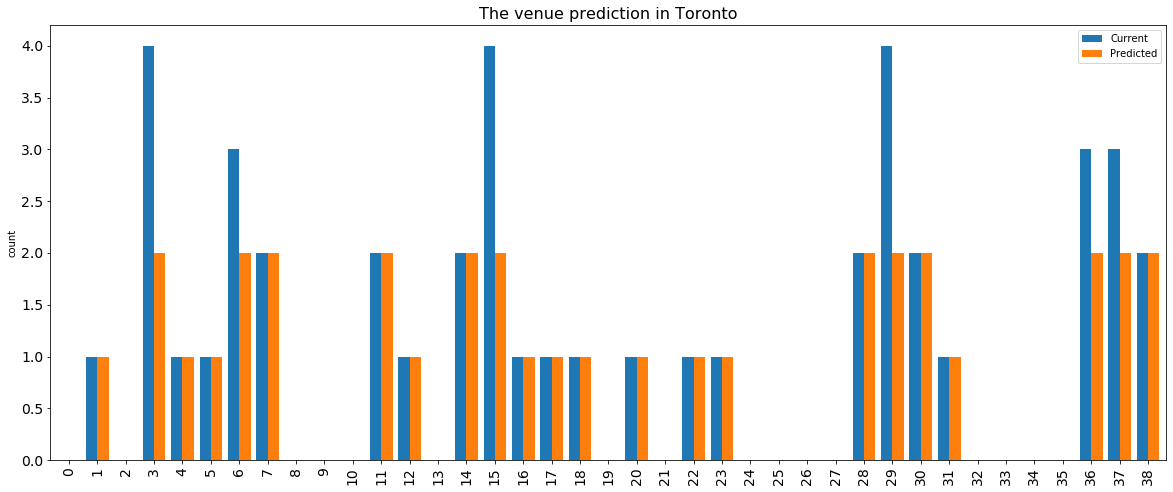

In [180]:
ax = compare[["Current","Predicted"]].plot(kind = "bar", figsize = (20,8), width = 0.8,  fontsize=14 )
ax.set_title("The venue prediction in Toronto", fontsize = 16)
ax.set_ylabel("count")

The bar plot shows that the result is good. Now, apply the model trained by Toronto data to Chicago.

In [183]:
template=pd.DataFrame(columns=df_toronto.columns)
template=template.merge(chicago_sum,how='outer')
print(template.shape)

(14, 267)


In [184]:
chicago_templated=template[df_toronto.columns].copy()
chicago_templated.fillna(0,inplace=True)
print(chicago_templated.shape)
chicago_templated.head()

(14, 235)


,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Cabrini–Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,2,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Dearborn Park,0,0,0,0,0,0,3,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,1,0,2,0,0,0,1,0,0,

In [185]:
X_test = chicago_templated.drop(['Neighborhood','Italian Restaurant'],axis=1)
y_test = chicago_sum['Italian Restaurant']

In [186]:
y_predict=model.predict(X_test)


In [187]:

y_predict = y_predict.astype(float).round().astype(int)

data = {'Neighborhood':chicago_sum['Neighborhood'],'Current':y_test,'Predicted':y_predict}

compare=pd.DataFrame(data)
compare=compare.set_index('Neighborhood')
compare.head()

,Current,Predicted
Neighborhood,,
Cabrini–Green,3,1
Dearborn Park,1,1
Loop,1,1
Magnificent Mile,4,1
New Eastside,1,0


Text(0, 0.5, 'Intalian Resuaurant Count')

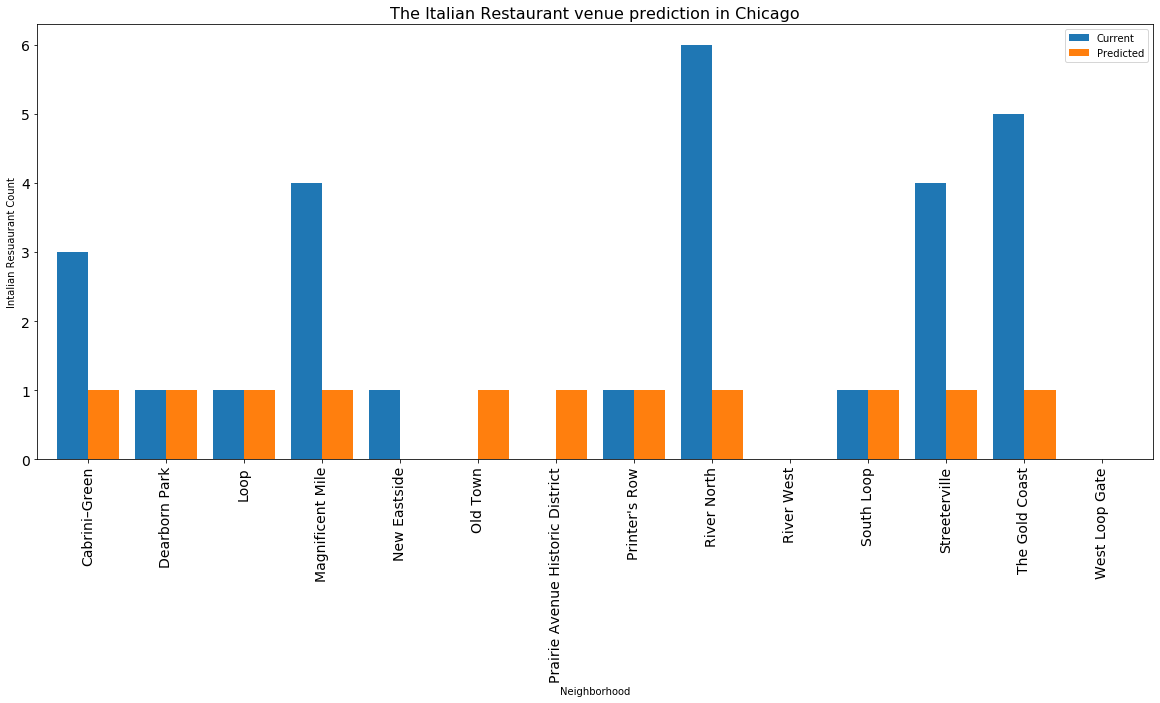

In [188]:
ax = compare[["Current","Predicted"]].plot(kind = "bar", figsize = (20,8), width = 0.8,  fontsize=14 )

ax.set_title("The Italian Restaurant venue prediction in Chicago", fontsize = 16)
ax.set_ylabel("Intalian Resuaurant Count")

Conclusion: acoording to the business environment, there are likely to have an Italian restaurant in Old Town or Prairie Avenue Historic Distinct.

Visualize the results of new restaurant.

In [199]:
neig_coord = df_coords.set_index('Neighborhood')

neig_coord

,Latitude,Longitude
Neighborhood,,
Cabrini–Green,41.871425,-87.653740
The Gold Coast,41.903950,-87.628860
Magnificent Mile,41.900580,-87.624210
Old Town,41.905390,-87.641790
River North,41.892520,-87.624770
River West,41.948787,-87.855967
Streeterville,41.898430,-87.621410
Loop,41.878340,-87.619970
New Eastside,41.712070,-87.530680


In [219]:
latlng = neig_coord.loc[['Old Town','Prairie Avenue Historic District']]
#lon = neig_coord.loc[['Old Town','Prairie Avenue Historic District'],"Longitude"]

#data = {'Neighborhood':df_toronto['Neighborhood'],'Current':y,'Predicted':y_predict}

#compare=pd.DataFrame(data)
latlng = latlng.reset_index()
latlng

,Neighborhood,Latitude,Longitude
0,Old Town,41.90539,-87.64179
1,Prairie Avenue Historic District,41.85642,-87.62088


In [225]:
#map_chicago = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, neighborhood in zip(latlng['Latitude'], latlng['Longitude'],latlng['Neighborhood']):
#add_markers(latlng)
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        popup="Our Restaurant!",
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)
map_chicago